In [1]:
# !wget https://huggingface.co/datasets/mesolitica/GCP-TTS/raw/main/gtts-text.json
# !wget https://huggingface.co/datasets/mesolitica/GCP-TTS/resolve/main/ms-MY-Wavenet-C.tar.gz

In [2]:
import parselmouth
import librosa
import pyworld as pw
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import malaya_speech
from malaya_speech import Pipeline
import json

`pyaudio` is not available, `malaya_speech.streaming.stream` is not able to use.


In [3]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.safe_load(fopen)
    
config

{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 60,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [4]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [5]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [6]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [7]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False, money = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = re.sub(r'[ ]+', ' ', string).strip()
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = True)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = ''.join([c for c in string if c in MALAYA_SPEECH_SYMBOLS])
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [8]:
with open('gtts-text.json') as fopen:
    texts = json.load(fopen)

In [11]:
!cp -r ~/ssd2/ms-MY-Wavenet-C .

In [12]:
txts = []
directory = 'ms-MY-Wavenet-C-audio'
for no, t in enumerate(texts):
    wav = f'ms-MY-Wavenet-C/{no}.mp3'
    if os.path.exists(wav):
        txts.append((wav, t, directory))

In [14]:
!mkdir {directory}

In [15]:
sound = AudioSegment.from_mp3(txts[0][0])
samples = sound.get_array_of_samples()
samples = np.array(samples)
samples = malaya_speech.astype.int_to_float(samples)
samples = malaya_speech.resample(samples, 24000, 22050)

In [16]:
import IPython.display as ipd
ipd.Audio(samples, rate = 22050)

In [17]:
import malaya_speech
import soundfile as sf
from malaya_speech import Pipeline
from tqdm import tqdm
vad = malaya_speech.vad.webrtc()

def process(txts, 
            start_silent_trail = int(0.15 * config['sampling_rate']),
            middle_silent_trail = int(0.2 * config['sampling_rate']),
            end_silent_trail = int(0.2 * config['sampling_rate']),
            process_middle_silent = True,
            maxlen = 25):
    
    txts = txts[0]
    audios, text_ids = [], []

    for f in tqdm(txts):
        directory = f[2]
        text = f[1]
        f = f[0]
            
        text = [text, tts_encode(text)]
        try:
            sound = AudioSegment.from_mp3(f)
            samples = sound.get_array_of_samples()
            samples = np.array(samples)
            samples = malaya_speech.astype.int_to_float(samples)
            audio = malaya_speech.resample(samples, 24000, 22050)
        except:
            continue
        # audio = audio[start_silent_trail:]

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.15)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-start_silent_trail:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:end_silent_trail]
                    else:
                        if process_middle_silent:
                            g = np.concatenate([g[0].array[:middle_silent_trail], g[0].array[-middle_silent_trail:]])
                        else:
                            g = g[0].array
                        
                r.append(g)
            audio = np.concatenate(r)
        
        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        f = os.path.split(f)[1].replace('.mp3', '.wav')
        new_f = f'{directory}/{f}'
        
        sf.write(new_f, audio, 22050)
        audios.append(new_f)
        text_ids.append(text)
    
    return [[audios, text_ids]]

In [18]:
i = 135
r = process((txts[i: i + 10],))[0]

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.92it/s]


In [19]:
r[0]

['ms-MY-Wavenet-C-audio/135.wav',
 'ms-MY-Wavenet-C-audio/136.wav',
 'ms-MY-Wavenet-C-audio/137.wav',
 'ms-MY-Wavenet-C-audio/138.wav',
 'ms-MY-Wavenet-C-audio/139.wav',
 'ms-MY-Wavenet-C-audio/140.wav',
 'ms-MY-Wavenet-C-audio/141.wav',
 'ms-MY-Wavenet-C-audio/142.wav',
 'ms-MY-Wavenet-C-audio/143.wav',
 'ms-MY-Wavenet-C-audio/144.wav']

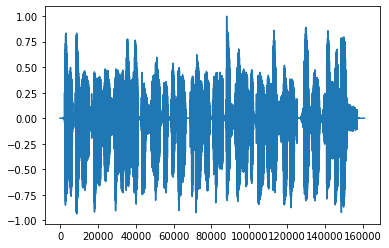

In [20]:
import matplotlib.pyplot as plt

y_ = sf.read(r[0][1])[0]
plt.plot(y_)

In [21]:
import mp

audios, text_ids = [], []
batch_size = 5000
for i in range(0, len(txts), batch_size):
    print(i)
    index = min(i + batch_size, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 5, returned = True)
    for result in results:
        audios.extend(result[0])
        text_ids.extend(result[1])

0


  9%|███▋                                     | 91/1000 [00:12<02:03,  7.34it/s]

skipped, audio too long


 79%|███████████████████████████████▋        | 793/1000 [01:42<00:28,  7.38it/s]

skipped, audio too long


 80%|███████████████████████████████▉        | 799/1000 [01:43<00:26,  7.64it/s]

skipped, audio too long


100%|███████████████████████████████████████| 1000/1000 [02:10<00:00,  7.69it/s]


5000


 19%|███████▋                                | 192/1000 [00:25<01:55,  6.99it/s]

skipped, audio too long


100%|███████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


10000


  3%|█                                        | 26/1000 [00:04<02:18,  7.05it/s]

skipped, audio too long


100%|███████████████████████████████████████| 1000/1000 [02:58<00:00,  5.59it/s]


15000


100%|███████████████████████████████████████| 1000/1000 [02:43<00:00,  6.10it/s]


20000


100%|███████████████████████████████████████| 1000/1000 [02:17<00:00,  7.27it/s]


25000


 21%|████████▏                               | 206/1000 [00:27<01:45,  7.52it/s]

skipped, audio too long


100%|███████████████████████████████████████| 1000/1000 [02:15<00:00,  7.39it/s]


30000


100%|█████████████████████████████████████████| 213/213 [00:28<00:00,  7.49it/s]


In [22]:
from tqdm import tqdm

data = []
for i in tqdm(range(len(audios))):
    data.append((os.path.join(os.getcwd(), audios[i]), text_ids[i][0]))

100%|████████████████████████████████| 31063/31063 [00:00<00:00, 1001827.49it/s]


In [23]:
import json

with open('ms-MY-Wavenet-C-vits.json', 'w') as fopen:
    json.dump(data, fopen)